SimCLR Implementation for single GPU setup

https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7

In [133]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt 

from sklearn.manifold import TSNE

In [3]:
def set_seed(seed=16):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

dir_CIFAR = "/home/hoseung/Work/datasets/"
!mkdir -p {dir_CIFAR}
!mv cifar-10-python.tar.gz {dir_CIFAR}
!tar -xf {dir_CIFAR+'cifar-10-python.tar.gz'} -C {dir_CIFAR}
dir_CIFAR += "cifar-10-batches-py/"
!ls {dir_CIFAR}

--2021-08-03 15:33:18--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  6.76MB/s    in 41s     

2021-08-03 15:34:01 (3.94 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


## Data Loader

In [5]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
train_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
images = np.array([], dtype=np.uint8).reshape((0,3072))
labels = np.array([])
for tf in train_files:
    data_dict = unpickle(dir_CIFAR+tf)
    data = data_dict[b'data']
    images = np.append(images, data, axis=0)
    labels = np.append(labels, data_dict[b'labels'])


testimages = np.array([],dtype=np.uint8).reshape((0,3072))
testlabels = np.array([])

data_dict = unpickle(dir_CIFAR+'/test_batch')
data = data_dict[b'data']
testimages = np.append(testimages,data,axis=0)
testlabels = np.append(testlabels,data_dict[b'labels'])


images = images.reshape((-1,3,32,32)).astype(float)
testimages = testimages.reshape((-1,3,32,32)).astype(float)

lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [7]:
# split 50K images 80:20.
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]
MEAN = np.mean(trimages/255.0,axis=(0,2,3),keepdims=True) # will use for normalization
STD = np.std(trimages/255.0,axis=(0,2,3),keepdims=True)

## Data Generator

In [23]:
import torchvision.transforms.functional as TF

In [26]:
tf = transforms.Compose([transforms.RandomHorizontalFlip(0.5)])

In [131]:
MEAN[:,:,:,0].shape

(1, 3, 1)

In [127]:
print(MEAN[0])

[[[0.49145363]]

 [[0.48206213]]

 [[0.44622512]]]


In [148]:
from PIL import Image
from torchvision.datasets import CIFAR10


class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])



class C10DataGen(Dataset):
    """   
    What is **frame**?
    """
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        tr_s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*tr_s, 
                                                                                                                 0.8*tr_s, 
                                                                                                                 0.8*tr_s, 
                                                                                                                 0.2*tr_s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])
        
    def __len__(self):
        return self.imgarr.shape[0]
    
    def __getitem__(self, idx):
        x = self.imgarr[idx]
        x = (x/255.0).astype(np.uint8)
        
        #x1 = self.augment(torch.from_numpy(x))
        x1 = self.augment(TF.to_pil_image(x))
        x2 = self.augment(TF.to_pil_image(x))
        #x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2
    
    def on_epoch_end(self):
        # shuffle the dataset
        #self.imgarr = self.imgarr[random.sample(list(range(self.__len__())),
        #                                        k = self.__len__())] # choose k sample from population.
        np.random.shuffle(self.imgarr) # shuffle images. -- np.random.shuffle only shuffles along the first axis.
        
    def preprocess(self, frame):
        frame = (frame-MEAN)/STD
        return frame
    
    def augment(self, frame, transformations = None):
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

Pytorch DataLoader expects a dataset (or data generator), each item of which is retrieved by `__get_item__()` or `__iter__()` depending on the type of dataset. 


## DataLoader

In [125]:
dg = C10DataGen('train', trimages)
dl = DataLoader(dg, batch_size=128, drop_last=True)

vdg = C10DataGen('valid', valimages)
vdl = DataLoader(vdg, batch_size=128, drop_last=True)

### torchvision.transforms
Most torchvision.transforms classes/functions support both Torch tensors and PIL images, but some only support one of the two.   
Use transforms.ToPILImage or transforms.ToTensor for conversions.

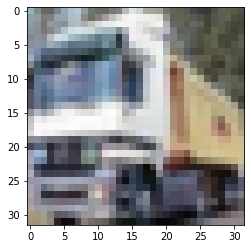

In [99]:
def swap21(img):
    #return ndarr.swapaxes(0,2).swapaxes(0,1)
    return np.transpose(img, (1,2,0))

plt.imshow(swap21(images[1]/255))
plt.show()

In [104]:
img = TF.to_pil_image(swap21(images[0]).astype(np.uint8))

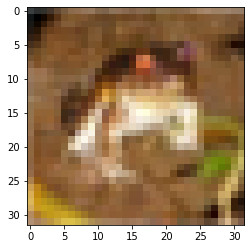

In [105]:
plt.imshow(img)

In [126]:
next(iter(dl))

ValueError: operands could not be broadcast together with shapes (32,32,3) (1,3,1,1) 

Or just the easy way

In [142]:
tr_s = 1
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomResizedCrop(32,(0.8,1.0)),
                                transforms.Compose([transforms.RandomApply(
                                   [transforms.ColorJitter(0.8*tr_s, 
                                                           0.8*tr_s, 
                                                           0.8*tr_s, 
                                                           0.2*tr_s)], p = 0.8),
                                transforms.RandomGrayscale(p=0.2)
                                     ])])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [143]:
dl = DataLoader(trainset, batch_size=128, drop_last=True)
vdl = DataLoader(testset, batch_size=128, drop_last=True)


In [144]:
next(iter(dl))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>